In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

Prepare environment

In [7]:
!mkdir checkpoints
!wget -O checkpoints/last_checkpoint https://www.dropbox.com/s/cs6zd9yntn6ixea/last_checkpoint?dl=1

!wget -O parameters.zip https://www.dropbox.com/s/n2jbjyq32x6jgr6/parameters.zip?dl=1
!unzip parameters.zip

mkdir: cannot create directory ‘checkpoints’: File exists
--2018-12-30 12:50:51--  https://www.dropbox.com/s/cs6zd9yntn6ixea/last_checkpoint?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.1, 2620:100:6026:1::a27d:4601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cs6zd9yntn6ixea/last_checkpoint [following]
--2018-12-30 12:50:51--  https://www.dropbox.com/s/dl/cs6zd9yntn6ixea/last_checkpoint
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce6bca547ca5c3213df6b9eba31.dl.dropboxusercontent.com/cd/0/get/AYfI1M7No_5wo9pUFrR1rwngKmOGHM5jP5KWBGtEdrqF5RUJXe-hlwGiXABVGodUnepjUjIX8im-4kBC9ftxKb5KGgIiteaV1ODuF3kbLOY6q-czybWShGDjj1w-SlhAP82mFz5__xEzIbLXdlZDNmdq5_UgSaPQB5o9_NGAuPZ7-4VKLw7ZOCGo0hePb394Bz8/file?dl=1 [following]
--2018-12-30 12:50:52--  https://uce6bca547ca5c3213df6b9eba31.dl.dropboxuser

In [3]:
import torch
import matplotlib.pyplot as plt

In [4]:
from model.transformer_model import TransformerModel
from model.text import BPEVocab
from model.utils import pad_sequence

In [5]:
from config import get_model_config
model_config = get_model_config()

In [6]:
from pprint import pprint
pprint(model_config)

{'annealing': 0,
 'annealing_topk': None,
 'attn_dropout': 0.1,
 'beam_size': 3,
 'bpe_codes_path': './parameters/bpe.code',
 'bpe_vocab_path': './parameters/bpe.vocab',
 'checkpoint_path': './checkpoints/last_checkpoint',
 'diversity_coef': 0,
 'diversity_groups': 1,
 'dropout': 0.1,
 'embed_dropout': 0.1,
 'embeddings_size': 768,
 'ff_dropout': 0.1,
 'length_penalty': 0.6,
 'max_seq_len': 256,
 'n_heads': 12,
 'n_layers': 12,
 'n_pos_embeddings': 512,
 'n_segments': None}


In [7]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
vocab = BPEVocab.from_files(model_config.bpe_vocab_path, model_config.bpe_codes_path)

In [9]:
model = TransformerModel(n_layers=model_config.n_layers,
                         n_embeddings=len(vocab),
                         n_pos_embeddings=model_config.n_pos_embeddings,
                         embeddings_size=model_config.embeddings_size,
                         padding_idx=vocab.pad_id,
                         n_heads=model_config.n_heads,
                         dropout=model_config.dropout,
                         embed_dropout=model_config.embed_dropout,
                         attn_dropout=model_config.attn_dropout,
                         ff_dropout=model_config.ff_dropout,
                         bos_id=vocab.bos_id,
                         eos_id=vocab.eos_id,
                         max_seq_len=256,
                         beam_size=3,
                         length_penalty=0.6,
                         n_segments=model_config.n_segments,
                         sample=False,
                         annealing_topk=None,
                         annealing=0.6,
                         diversity_coef=0,
                         diversity_groups=1)

In [10]:
torch.set_grad_enabled(False)
state_dict = torch.load(model_config.checkpoint_path, map_location=lambda storage, loc: storage)

if 'model' in state_dict:
    state_dict = state_dict['model']

model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

TransformerModel(
  (transformer_module): TransformerModule(
    (embeddings): Embedding(40485, 768, padding_idx=0)
    (pos_embeddings): Embedding(513, 768, padding_idx=0)
    (embed_dropout): Dropout(p=0.1)
    (layers): ModuleList(
      (0): TransformerBlock(
        (attn): MultiheadAttention(
          (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1)
        )
        (attn_norm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
        (ff): FeedForward(
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1)
        )
        (ff_norm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1)
      )
      (1): TransformerBlock(
        (attn): MultiheadAttention(
   

In [11]:
!nvidia-smi

Wed Jan  2 18:24:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.24.02              Driver Version: 396.24.02                 |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   49C    P2    41W / 180W |    967MiB /  8119MiB |     46%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1070    Off  | 00000000:04:00.0  On |                  N/A |
|  0%   49C    P8    12W / 180W |     82MiB /  8116MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [12]:
def model_responce(encoded_context, max_len=255):
    prevs = [[vocab.bos_id]]
    
    dump = []
    
    for _ in range(max_len):
#         print(30*'-')
#         print(30*'-')
#         print(30*'-')
        prevs_t = torch.tensor(prevs, dtype=torch.long, device=device)
        
        current_dump = []
        outputs = model.decode(prevs_t, encoded_context, dump=current_dump)

        _, m_idx = torch.max(outputs[:, -1, :], dim=-1)
        m_idx = m_idx.item()
        
        dump.append((m_idx, current_dump))

        prevs[0].append(m_idx)

        if m_idx == vocab.eos_id:
            break
#         break
    return prevs[0], dump

In [13]:
def read_info(max_sequences=4, max_len=255):
    info = []
    for _ in range(max_sequences):
        new_info = input('Info: ').lower().strip()
        
        if new_info == 'exit':
            break
        
        if not new_info.endswith('.'):
            new_info += '.'
            
#         print(new_info)
        
        info += vocab.string2ids(new_info)
    
    if info:
        info = [vocab.info_bos_id] + info[:model.n_pos_embeddings-2] + [vocab.info_eos_id]
        info = [torch.tensor(info, dtype=torch.long)]
        info = pad_sequence(info, batch_first=True, padding_value=vocab.pad_id).to(device)
        
    return info


In [14]:
def simple_interactive():
    
    info = read_info()
#     print('1' if info else '2')
#     return
    
    dialog = []
    while True:
        new_message = input('H: ').lower().strip()
#         print(new_message)
        
        if new_message == 'exit':
            break
        
        dialog += [vocab.talker1_bos_id] + vocab.string2ids(new_message) + [vocab.talker1_eos_id]
        
        t_dialog = [torch.tensor(dialog[-model_config.embeddings_size+1:], dtype=torch.long)]
        t_dialog = pad_sequence(t_dialog, batch_first=True, padding_value=vocab.pad_id).to(device)
        
        context = []
        if len(info):
            context.append(info)
        context.append(t_dialog)

        encoded_context = [model.encode(c) for c in context]
        
        res_indx, dump = model_responce(encoded_context)
        res_indx = res_indx[1:-1]
        
        print(f'B: {vocab.ids2string(res_indx)}')
        
        return dump
        
        dialog += [vocab.talker2_bos_id] + res_indx + [vocab.talker2_eos_id]
        
#         print(t_dialog)
#         print(dialog)
        


In [15]:
dump = simple_interactive()

Info: exit
H: hi
layer_num: 0 | run_i: 0 | - q_size: torch.Size([1, 3, 768])
layer_num: 0 | run_i: 0 | - k_size: torch.Size([1, 3, 768])
layer_num: 0 | run_i: 0 | - v_size: torch.Size([1, 3, 768])
layer_num: 0 | run_i: 0 | - qkv_same: True
layer_num: 0 | run_i: 0 | - kv_same: True
layer_num: 0 | run_i: 0 | + q_size: torch.Size([1, 3, 768])
layer_num: 0 | run_i: 0 | _split_heads | input x size: x (batch_size, seq_len, num_features) torch.Size([1, 3, 768])
layer_num: 0 | run_i: 0 | _split_heads | view x size: x (batch_size, seq_len, self.n_heads, num_features // self.n_heads) torch.Size([1, 3, 12, 64])
layer_num: 0 | run_i: 0 | _split_heads | permute x size: torch.Size([1, 12, 3, 64])
layer_num: 0 | run_i: 0 | = q_size: torch.Size([1, 12, 3, 64])
layer_num: 0 | run_i: 0 | + k_size: torch.Size([1, 3, 768])
layer_num: 0 | run_i: 0 | _split_heads | input x size: x (batch_size, seq_len, num_features) torch.Size([1, 3, 768])
layer_num: 0 | run_i: 0 | _split_heads | view x size: x (batch_size,

layer_num: 2 | run_i: 1 | _attn | w = q * k: torch.Size([1, 12, 2, 3])
layer_num: 2 | run_i: 1 | dump is not none
layer_num: 2 | run_i: 1 | w_sizetorch.Size([1, 12, 2, 3])
layer_num: 2 | run_i: 1 | v_sizetorch.Size([1, 12, 3, 64])
layer_num: 2 | run_i: 1 | _merge_heads | input x size: torch.Size([1, 12, 2, 64])
layer_num: 2 | run_i: 1 | _merge_heads | permute x size: torch.Size([1, 2, 12, 64])
layer_num: 2 | run_i: 1 | _merge_heads | view x size: torch.Size([1, 2, 768])
layer_num: 3 | run_i: 0 | - q_size: torch.Size([1, 2, 768])
layer_num: 3 | run_i: 0 | - k_size: torch.Size([1, 2, 768])
layer_num: 3 | run_i: 0 | - v_size: torch.Size([1, 2, 768])
layer_num: 3 | run_i: 0 | - qkv_same: True
layer_num: 3 | run_i: 0 | - kv_same: True
layer_num: 3 | run_i: 0 | + q_size: torch.Size([1, 2, 768])
layer_num: 3 | run_i: 0 | _split_heads | input x size: x (batch_size, seq_len, num_features) torch.Size([1, 2, 768])
layer_num: 3 | run_i: 0 | _split_heads | view x size: x (batch_size, seq_len, self.

layer_num: 3 | run_i: 1 | _split_heads | permute x size: torch.Size([1, 12, 3, 64])
layer_num: 3 | run_i: 1 | = v_size: torch.Size([1, 12, 3, 64])
layer_num: 3 | run_i: 1 | _attn | q size: torch.Size([1, 12, 4, 64])
layer_num: 3 | run_i: 1 | _attn | k size: torch.Size([1, 12, 64, 3])
layer_num: 3 | run_i: 1 | _attn | v size: torch.Size([1, 12, 3, 64])
layer_num: 3 | run_i: 1 | _attn | w = q * k: torch.Size([1, 12, 4, 3])
layer_num: 3 | run_i: 1 | dump is not none
layer_num: 3 | run_i: 1 | w_sizetorch.Size([1, 12, 4, 3])
layer_num: 3 | run_i: 1 | v_sizetorch.Size([1, 12, 3, 64])
layer_num: 3 | run_i: 1 | _merge_heads | input x size: torch.Size([1, 12, 4, 64])
layer_num: 3 | run_i: 1 | _merge_heads | permute x size: torch.Size([1, 4, 12, 64])
layer_num: 3 | run_i: 1 | _merge_heads | view x size: torch.Size([1, 4, 768])
layer_num: 4 | run_i: 0 | - q_size: torch.Size([1, 4, 768])
layer_num: 4 | run_i: 0 | - k_size: torch.Size([1, 4, 768])
layer_num: 4 | run_i: 0 | - v_size: torch.Size([1, 

layer_num: 5 | run_i: 0 | - q_size: torch.Size([1, 6, 768])
layer_num: 5 | run_i: 0 | - k_size: torch.Size([1, 6, 768])
layer_num: 5 | run_i: 0 | - v_size: torch.Size([1, 6, 768])
layer_num: 5 | run_i: 0 | - qkv_same: True
layer_num: 5 | run_i: 0 | - kv_same: True
layer_num: 5 | run_i: 0 | + q_size: torch.Size([1, 6, 768])
layer_num: 5 | run_i: 0 | _split_heads | input x size: x (batch_size, seq_len, num_features) torch.Size([1, 6, 768])
layer_num: 5 | run_i: 0 | _split_heads | view x size: x (batch_size, seq_len, self.n_heads, num_features // self.n_heads) torch.Size([1, 6, 12, 64])
layer_num: 5 | run_i: 0 | _split_heads | permute x size: torch.Size([1, 12, 6, 64])
layer_num: 5 | run_i: 0 | = q_size: torch.Size([1, 12, 6, 64])
layer_num: 5 | run_i: 0 | + k_size: torch.Size([1, 6, 768])
layer_num: 5 | run_i: 0 | _split_heads | input x size: x (batch_size, seq_len, num_features) torch.Size([1, 6, 768])
layer_num: 5 | run_i: 0 | _split_heads | view x size: x (batch_size, seq_len, self.n_

In [104]:
vocab.id2token[3578]

'hello</w>'

In [138]:
input_info_string = 'i am software developer.'
input_info_ids = [vocab.info_bos_id] + vocab.string2ids(input_info_string) + [vocab.info_eos_id]
input_info_tokens = [vocab.id2token[i] for i in input_info_ids]

print(f'Input info string: {input_info_string}')
print(f'Input info indexes: {input_info_ids}')
print(f'Input info tokens: {input_info_tokens}')

Input info string: i am software developer.
Input info indexes: [3, 257, 1056, 15540, 4305, 6495, 247, 4]
Input info tokens: ['<i>', 'i</w>', 'am</w>', 'software</w>', 'devel', 'oper</w>', '.</w>', '</i>']


In [139]:
input_dialog_string = 'hi, who are you?'
input_dialog_ids = [vocab.talker1_bos_id] + vocab.string2ids(input_dialog_string) + [vocab.talker1_eos_id]
input_dialog_tokens = [vocab.id2token[i] for i in input_dialog_ids]

print(f'Input dialog string: {input_dialog_string}')
print(f'Input dialog indexes: {input_dialog_ids}')
print(f'Input dialog tokens: {input_dialog_tokens}')

Input dialog string: hi, who are you?
Input dialog indexes: [5, 3577, 248, 771, 648, 520, 265, 6]
Input dialog tokens: ['<t1>', 'hi</w>', ',</w>', 'who</w>', 'are</w>', 'you</w>', '?</w>', '</t1>']


In [144]:
len(dump)

14

In [173]:
import numpy as np

n_layers = 12
n_heads = 12
n_context = 3

n = 0

out_ids = []

dialog_weights = np.zeros((n_layers, n_heads, len(input_dialog_tokens), len(dump)))
info_weights = np.zeros((n_layers, n_heads, len(input_info_tokens), len(dump)))
self_weights = np.zeros((n_layers, n_heads, len(dump), len(dump))) + np.nan

for i, (idx, d) in enumerate(dump):
    out_ids.append(idx)
    
    for l_i, l in enumerate(range(n, n_context * n_layers, n_context)):
        for h in range(n_heads):
            
            current_dump = d[l]
            
            self_weights[l_i, h, :i+1, i] = current_dump[2][0, h, -1].numpy()
            
            current_dump = d[l+1]
            
            assert current_dump[0] == l_i
            assert current_dump[1] == 1, f' {l_i}, {l}, {current_dump[1]} 1'
            
            info_weights[l_i, h, :, i] = current_dump[2][0, h, -1].numpy()
            
            current_dump = d[l+2]
            
            dialog_weights[l_i, h, :, i] = current_dump[2][0, h, -1].numpy()
#     weights.append(d[23][2][0, 11, -1].numpy().reshape(-1, 1))
#     print(f'indx: {i} | indx2str: {vocab.id2token[i]} | {d[23][2][0, 11, -1].size()}')

out_ids = [vocab.bos_id] + out_ids
out_tokens = [vocab.id2token[i] for i in out_ids]

In [174]:
dialog_weights.shape

(12, 12, 8, 14)

In [175]:
info_weights.shape

(12, 12, 8, 14)

In [176]:
self_weights.shape

(12, 12, 14, 14)

In [167]:
from itertools import product


# for l_i, h_i in product(range(11, weights.shape[0]), range(weights.shape[1])):
#     plot_heatmap(weights[l_i, h_i], input_tokens, out_tokens[1:], title=f'layer {l_i + 1} | head {h_i + 1}')

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


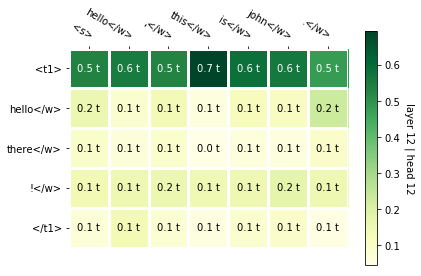

In [100]:
plot_heatmap(weights[11, 11], input_tokens, out_tokens, title='layer 12 | head 12')

In [182]:
def plot_heatmap(data, row_labels, col_labels, title=''):
    fig, ax = plt.subplots(len(row_labels), 1, figsize=(14, 18))
    
    print(ax)
    
    for i, (d, r) in enumerate(zip(data, row_labels)):
        im, cbar = heatmap(d, r, col_labels,  ax=ax[i], cmap="YlGn", cbarlabel=title)
        texts = annotate_heatmap(im, valfmt="{x:.1f} t")

        fig.tight_layout()
#     plt.show()

In [183]:
# %matplotlib interactive


from ipywidgets import interactive


def interactive_plot(layer=1, head=1):
    plot_heatmap([self_weights[layer, head],
                  dialog_weights[layer, head], 
                  info_weights[layer, head]], 
                 [out_tokens,
                  input_dialog_tokens, 
                  input_info_tokens], 
                 out_tokens[1:], title=f'layer {layer} | head {head}')
    
    
interactive(interactive_plot, layer=(0, 11, 1), head=(0, 11, 1))
    


interactive(children=(IntSlider(value=1, description='layer', max=11), IntSlider(value=1, description='head', …

In [186]:
def interactive_average_plot(layer=1):
    plot_heatmap([np.mean(self_weights[layer, :], axis=0),
                  np.mean(dialog_weights[layer, :], axis=0), 
                  np.mean(info_weights[layer, :], axis=0)], 
                 [out_tokens,
                  input_dialog_tokens, 
                  input_info_tokens], 
                 out_tokens[1:], title=f'layer {layer}')
    
    
interactive(interactive_average_plot, layer=(0, 11, 1), head=(0, 11, 1))

interactive(children=(IntSlider(value=1, description='layer', max=11), Output()), _dom_classes=('widget-intera…